In [2]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("dataset/track_" + no + ".csv", parse_dates=["date"])

In [3]:
equipments={}
for no in ['A','B','C','D']:
    equipments[no] = pd.read_csv("dataset/equipment_" + no + ".csv")

In [4]:
import datetime

In [5]:
from tqdm import tqdm

In [6]:
'''
%%time
all_summarys = pd.DataFrame()
for no in tqdm(['A','B','C','D']):
    track = tracks[no]
    equipment = equipments[no]
    all_summary = pd.DataFrame(columns=['路線', 'キロ程'])
    all_summary['キロ程'] = track['キロ程'].unique()
    all_summary['路線'] = no

    all_summary = pd.concat([all_summary, equipment.drop('キロ程', axis=1)], axis=1)

    all_summarys = pd.concat([all_summarys, all_summary], axis=0)
all_summarys = all_summarys.reset_index(drop=True)
'''

"\n%%time\nall_summarys = pd.DataFrame()\nfor no in tqdm(['A','B','C','D']):\n    track = tracks[no]\n    equipment = equipments[no]\n    all_summary = pd.DataFrame(columns=['路線', 'キロ程'])\n    all_summary['キロ程'] = track['キロ程'].unique()\n    all_summary['路線'] = no\n\n    all_summary = pd.concat([all_summary, equipment.drop('キロ程', axis=1)], axis=1)\n\n    all_summarys = pd.concat([all_summarys, all_summary], axis=0)\nall_summarys = all_summarys.reset_index(drop=True)\n"

In [7]:
import pandas_profiling as pdp

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_

In [8]:
from sklearn import svm

In [11]:
import changefinder

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [80]:
import random
random.seed(0)

/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if iss

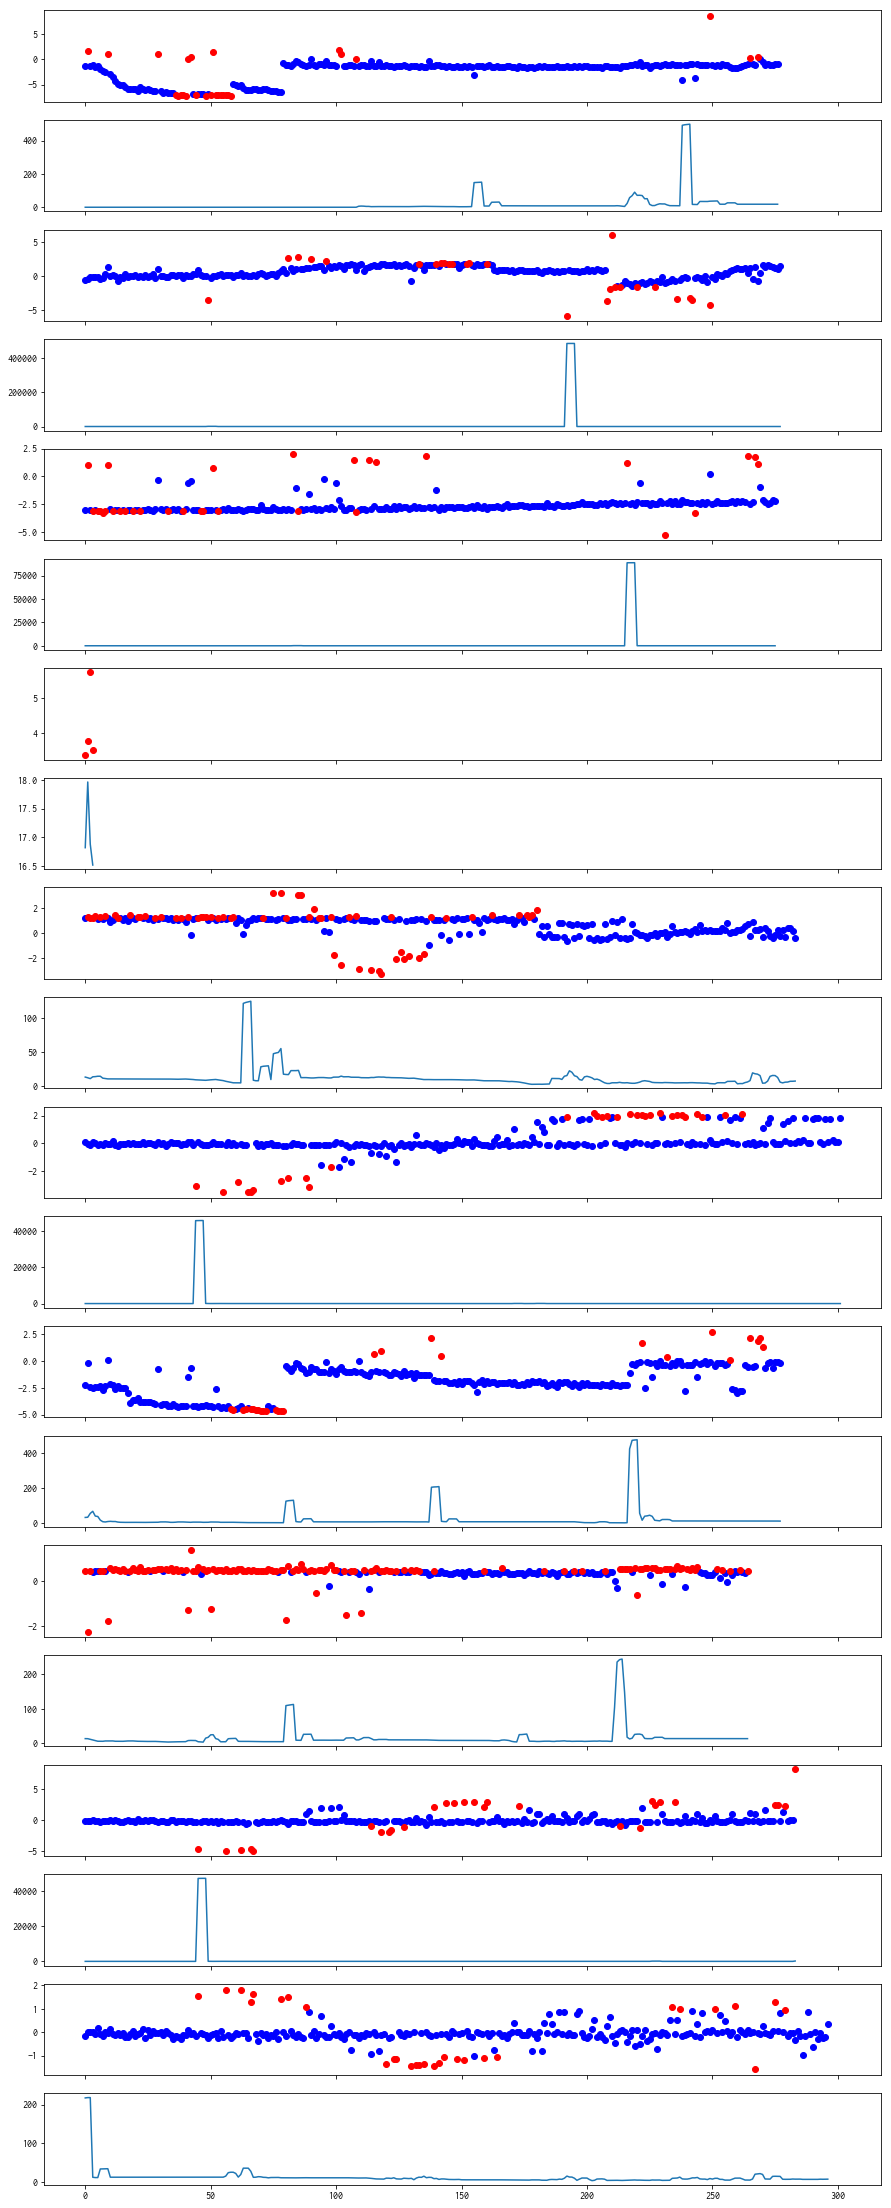

In [91]:
clf = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma=0.0001)
cf = changefinder.ChangeFinder(r=0.01, order=1, smooth=15)
#cf = changefinder.ChangeFinderARIMA(term=50, smooth=7, order=(1, 0, 0))
track = tracks['A']
fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

for i, rnd in enumerate(random.sample(list(track['キロ程'].unique()), 10)):
    data = track[track["キロ程"] == rnd]["高低左"].dropna()
    data = data.reset_index(drop=True)
    X = data.values
    X = X.reshape([len(X), 1])
    clf.fit(X)
    y_pred = clf.predict(X)

    check_outlier = pd.DataFrame(data)
    check_outlier['out'] = y_pred

    axes[i*2].scatter(check_outlier[check_outlier['out'] == 1].index, check_outlier.loc[check_outlier['out'] == 1, '高低左'], c='b')
    axes[i*2].scatter(check_outlier[check_outlier['out'] == -1].index, check_outlier.loc[check_outlier['out'] == -1, '高低左'], c='r')
    
    ret = []
    for j in data:
        score = cf.update(j)
        ret.append(score)

    axes[i*2+1].plot(ret)

In [94]:
from fbprophet import Prophet

In [113]:
data = pd.DataFrame(columns=['ds', 'y'])

track = tracks['A']
track = track.dropna(subset=['高低左'])
kilo = 11111
track = track[track['キロ程'] == kilo]
track = track.reset_index(drop=True)

data['ds'] = track['date']
data['y'] = track['高低左']
model = Prophet(growth='linear', daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(data)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/Users/a0082273/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


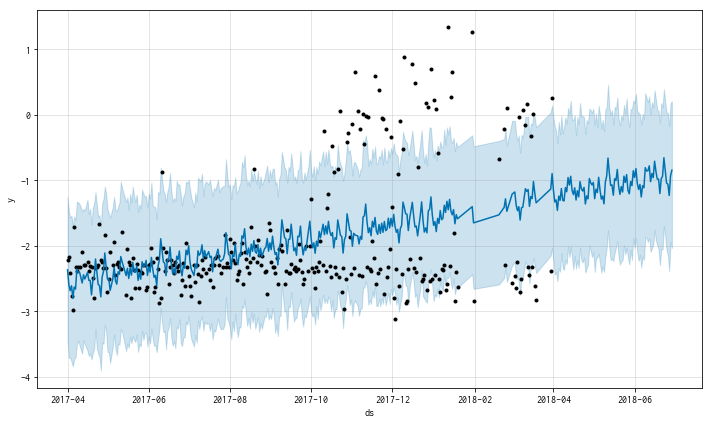

In [114]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)
model.plot(forecast)
plt.show()

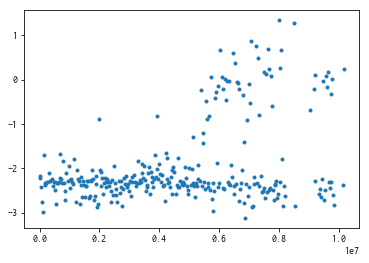

In [115]:
plt.plot(tracks['A'][tracks['A']['キロ程'] == 11111]['高低左'], marker='.', linewidth=0)

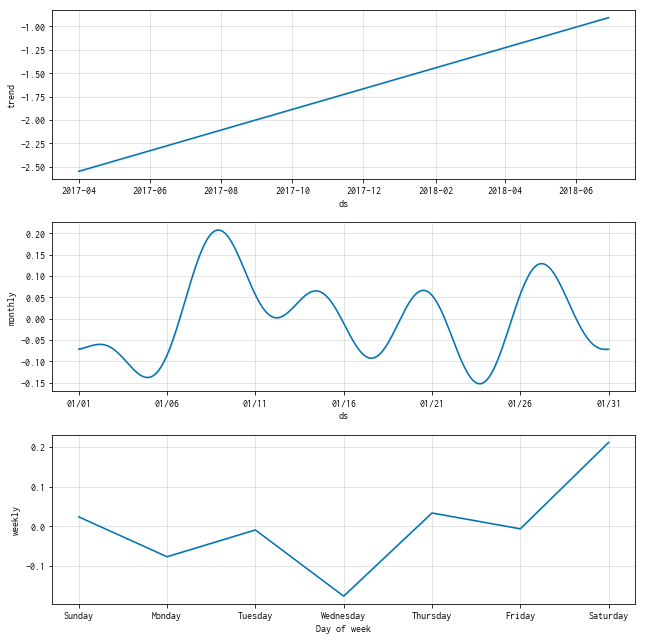

In [116]:
model.plot_components(forecast)
plt.show()

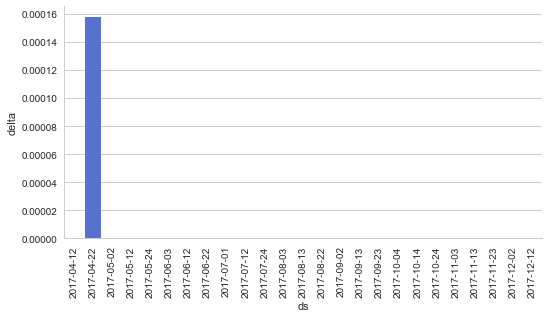

In [120]:
# add change rates to changepoints
df_changepoints = data.loc[model.changepoints.index]
df_changepoints['delta'] = model.params['delta'].ravel()

# get changepoints
df_changepoints['ds'] = df_changepoints['ds'].astype(str)
df_selection = df_changepoints[df_changepoints['delta'] != 0]
date_changepoints = df_selection['ds'].astype('datetime64[ns]').reset_index(drop=True)

# plot
sns.set(style='whitegrid')
ax = sns.factorplot(x='ds', y='delta', data=df_changepoints, kind='bar', color='royalblue', size=4, aspect=2)
ax.set_xticklabels(rotation=90)

# 中央値から遠くを除いて傾きを求める。最後の100個から切片求めて、線形回帰。

In [163]:
def remove_outliers(df):
    median = np.median(df['高低左'])
    df.loc[abs(df['高低左'] - median) > 0.5, 'flag'] = 1
    return df

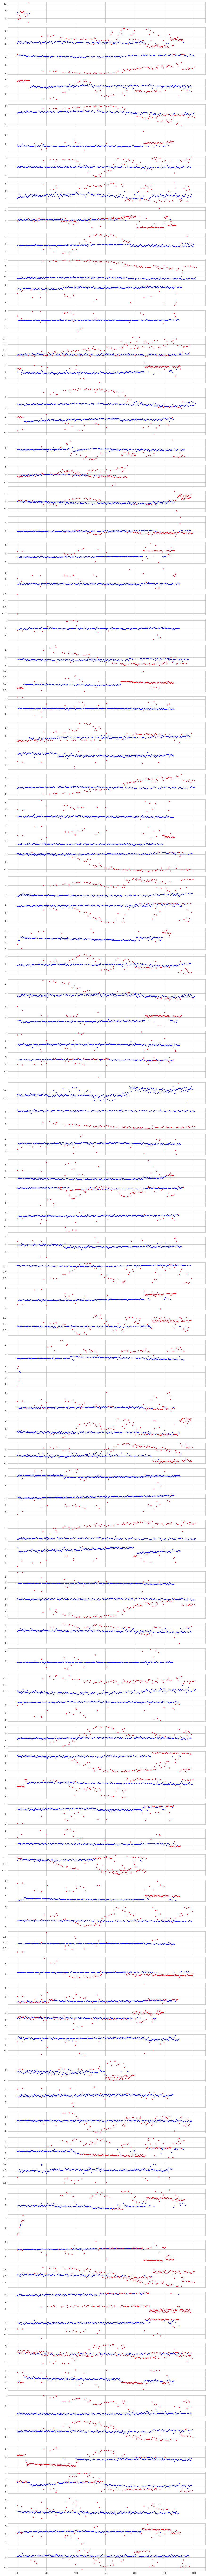

In [165]:
fig, axes = plt.subplots(100, 1, figsize=(15, 200), sharex=True)

track = tracks['A']
track = track.dropna(subset=['高低左'])
for i, rnd in enumerate(random.sample(list(track['キロ程'].unique()), 100)):
    data = track[track['キロ程'] == rnd]
    data = data.reset_index(drop=True)
    data = remove_outliers(data)
    axes[i].plot(data['高低左'], marker='.', linewidth=0, c='b')
    axes[i].plot(data.loc[data['flag'] == 1, ['高低左']], marker='.', linewidth=0, c='r')

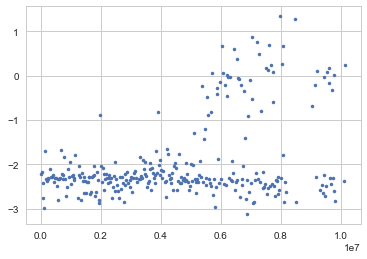

In [126]:
plt.plot(tracks['A'][tracks['A']['キロ程'] == 11111]['高低左'], marker='.', linewidth=0)

In [0]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return day

In [22]:
get_day([tracks['A'].loc[0, 'date'], tracks['A'].loc[len(tracks['A'])-1, 'date']])

[0, 364]

In [0]:
from sklearn.linear_model import LinearRegression

In [0]:
def get_slope(day, koutei):
    X = day
    X = [[x] for x in X]
    y = koutei

    clf = LinearRegression()
    clf.fit(X, y)
    slope = clf.coef_[0]
    sigma = np.std(clf.predict(X) - y)

    return slope, sigma

In [43]:
for no in ['A','B','C','D']:
    print(len(tracks[no]))

10185690
7815753
20324660
5601687


In [44]:
for no in ['A','B','C','D']:
    print(len(tracks[no]['キロ程'].unique()))

27906
21531
55684
15691


In [58]:
%%time
rand_summarys = pd.DataFrame()
for no in tqdm(['A','B','C','D']):
    track = tracks[no]
    equipment = equipments[no]

    track = track.dropna(subset=['高低左'])
    track = track.reset_index(drop=True)
    
    kilos = random.sample(list(track['キロ程'].unique()), 10)
    track = track[track['キロ程'].isin(kilos)]
    equipment = equipment[equipment['キロ程'].isin(kilos)]
    equipment = equipment.reset_index(drop=True)

    slopes = []
    sokuteis = []
    sigmas = []
    for kilo in tqdm(kilos):
        dates = track.loc[track['キロ程'] == kilo, 'date']
        day = get_day(dates)
        koutei = track.loc[track['キロ程'] == kilo, '高低左']
        slope, sigma = get_slope(day, koutei)
        slopes.append(slope)
        sigmas.append(sigma)
        sokutei = len(day)
        sokuteis.append(sokutei)

    rand_summary = pd.DataFrame(columns=['路線', 'キロ程', '傾き', '標準偏差', '測定回数'])
    rand_summary['キロ程'] = kilos
    rand_summary['路線'] = no
    rand_summary['傾き'] = slopes
    rand_summary['標準偏差'] = sigmas
    rand_summary['測定回数'] = sokuteis

    rand_summary = pd.concat([rand_summary, equipment.drop('キロ程', axis=1)], axis=1)

    rand_summarys = pd.concat([rand_summarys, rand_summary], axis=0)
rand_summarys = rand_summarys.reset_index(drop=True)

100%|██████████| 4/4 [00:03<00:00,  1.00s/it]

CPU times: user 3.91 s, sys: 100 ms, total: 4.01 s
Wall time: 4 s


In [59]:
rand_summarys

,路線,キロ程,傾き,標準偏差,測定回数,バラスト,ロングレール,マクラギ種別,橋りょう,踏切,通トン,曲線半径,フラグ
0,A,36847,0.000388,0.533894,265,0,1,1,0,0,0.000,0,0
1,A,21594,-0.001596,0.629075,298,1,1,1,0,0,11.579,1600,0
2,A,28383,0.000260,1.249636,266,1,0,3,0,0,11.579,0,1
3,A,25731,0.000178,0.903861,276,0,1,1,0,0,12.237,3000,0
4,A,36716,-0.000667,0.549004,266,0,1,1,0,0,12.237,3000,0
5,A,36300,-0.005312,0.906760,265,1,1,1,0,0,11.059,1000,0
6,A,21816,-0.002584,0.625124,297,1,1,1,0,0,8.456,1000,1
7,A,13703,-0.006884,1.872346,302,1,1,1,0,0,8.073,1000,0
8,A,19215,-0.000900,0.269833,299,1,1,1,0,0,8.073,1000,0
9,A,19451,0.001480,1.925782,295,1,1,1,0,0,8.073,1000,0


In [68]:
tracks['A'].head()

,date,キロ程,高低左,高低右,通り左,通り右,水準,軌間,速度
0,2017-04-01,10000,-1.16,-0.23,1.20,1.20,0.83,3.89,84.0
1,2017-04-01,10001,-1.17,-0.30,1.88,1.88,0.67,4.63,84.0
2,2017-04-01,10002,-1.09,-0.19,2.30,2.30,0.50,5.33,84.0
3,2017-04-01,10003,-0.64,0.20,2.28,2.28,0.46,5.90,84.0
4,2017-04-01,10004,0.47,0.89,1.74,1.74,0.62,6.38,84.5


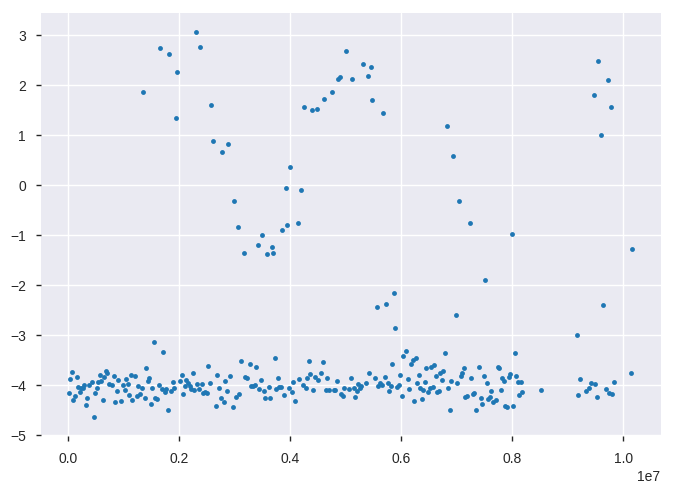

In [66]:
plt.plot(tracks['A'][tracks['A']['キロ程'] == 19451]['高低左'], marker='.', linewidth=0)

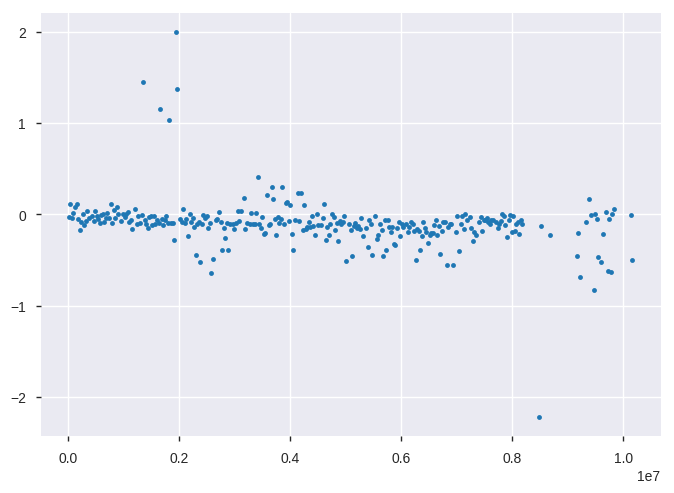

In [67]:
plt.plot(tracks['A'][tracks['A']['キロ程'] == 	19215]['高低左'], marker='.', linewidth=0)

In [0]:
rand_summarys.to_csv('summary.csv')

In [0]:
rand_summarys = pd.read_csv('summary.csv', index_col=0)

In [42]:
pdp.ProfileReport(rand_summarys)

Number of variables,11
Number of observations,40000
Total Missing (%),0.0%
Total size in memory,3.4 MiB
Average record size in memory,88.0 B
Numeric,5
Categorical,1
Boolean,5
Date,0
Text (Unique),0
Rejected,0


In [0]:
pdp.ProfileReport(all_summarys)